In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%reload_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm 

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader


%cd "/content/drive/My Drive/ml-project-2-marmlla_2/"
import Helper.Preprocessing as pp 
import Helper.Model as ml 
import Helper.Display as ds
import Helper.Pipeline as pl

/content/drive/My Drive/ml-project-2-marmlla_2


In [3]:
df = pd.read_csv("Data/dataset.csv")
df.head(2)

,Date,SMI,SP500,USD_CHF,BondCH,BondUS
0,2003-09-17,5398.899902,1025.97,1.3807,3.700,5.71
1,2003-09-18,5422.600098,1039.58,1.3858,3.716,5.69


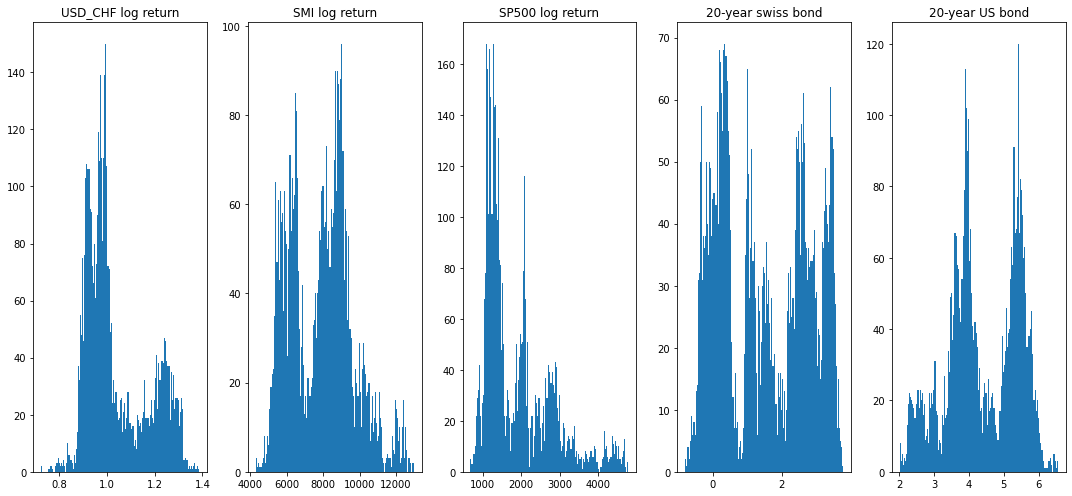

In [4]:
data = [df.USD_CHF, df.SMI, df.SP500, df.BondCH, df.BondUS]

fig = plt.figure(figsize=(15, 7))

name  = ['USD_CHF log return','SMI log return', 'SP500 log return', '20-year swiss bond', '20-year US bond']
for i in range(len(data)):   
    plt.subplot(1,len(data),1+i)
    plt.hist(data[i], bins=150)
    plt.title(name[i])
plt.tight_layout()
plt.show()

In [5]:
train_x, val_x, test_x, train_y, val_y, test_y, norm = pp.generate_dataset(data, lookback_=5, norm_=False, fraction_val_=0.1, fraction_test_=0.15)

Shape:             
X train     (3447, 5, 5), y train     (3447, 5)            
X train val (383, 5, 5) , y train val (383, 5)             
X test      (676, 5, 5) , y test      (676, 5)


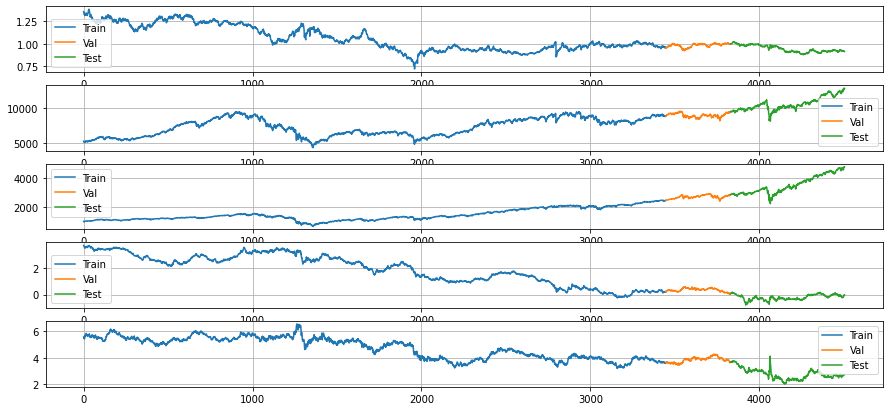

In [6]:

l1 = len(train_x)
l2 = len(val_x) + l1
l3 = len(test_x) + l2 

fig = plt.figure(figsize=(15, 7))
nb_data = len(data)
for i in range(nb_data):
  plt.subplot(nb_data,1,i+1)
  plt.plot(np.arange(l1), train_y[:,i], label='Train')
  plt.plot(np.arange(l1, l2), val_y[:,i], label='Val')
  plt.plot(np.arange(l2,l3), test_y[:,i], label='Test')
  plt.grid()
  plt.legend()

plt.show()

In [7]:
def get_bool(data_x, data_y): 
  y_bool = data_y.copy()
  for i in range(5):
    buff = y_bool[:,i]
    buff[buff > data_x[:,-1, i]] =  1
    buff[buff <= data_x[:,-1, i]] =  0
  return y_bool

train_y_bool = get_bool(train_x, train_y)
val_y_bool  = get_bool(val_x, val_y)
test_y_bool = get_bool(test_x, test_y)

# Trend Prediction

### GRU (ONLY USD_CHF)

In [10]:
model_gru = ml.GRU_base(
        hidden_size=50,
        num_layers=2,
        input_size=1,
        out_features_lin=50,
        out_features_end=1,
        dropout=0.0)
#model_gru.to('cuda')
model_gru

GRU_base(
  (gru): GRU(1, 50, num_layers=2, batch_first=True)
  (fc0_bn): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=50, out_features=50, bias=True)
  (fc1_bn): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
)

 20%|██        | 3/15 [00:01<00:06,  1.77it/s]

Epoch: 3/15
MSE = [train loss mean :  0.95445322] , [val loss mean:  0.51958225, MSE (last) 51.95822%]
nb 0: 383, nb 1: 0


 40%|████      | 6/15 [00:02<00:03,  2.31it/s]

Epoch: 6/15
MSE = [train loss mean :  0.84754333] , [val loss mean:  0.51958225, MSE (last) 51.95822%]
nb 0: 383, nb 1: 0


 60%|██████    | 9/15 [00:04<00:02,  2.40it/s]

Epoch: 9/15
MSE = [train loss mean :  0.78462799] , [val loss mean:  0.51958225, MSE (last) 51.95822%]
nb 0: 383, nb 1: 0


 80%|████████  | 12/15 [00:05<00:01,  2.46it/s]

Epoch: 12/15
MSE = [train loss mean :  0.76163730] , [val loss mean:  0.51958225, MSE (last) 51.95822%]
nb 0: 383, nb 1: 0


100%|██████████| 15/15 [00:06<00:00,  2.45it/s]

Epoch: 15/15
MSE = [train loss mean :  0.73983998] , [val loss mean:  0.54134030, MSE (last) 56.65796%]
nb 0: 241, nb 1: 142


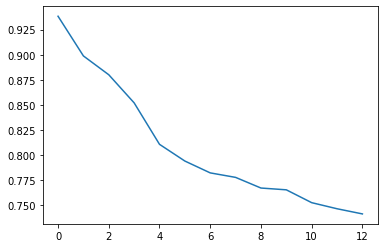

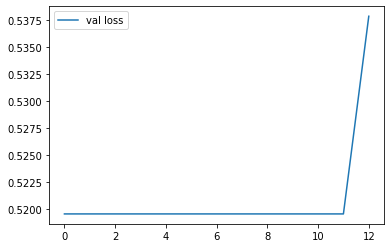

In [11]:
train_loss, val_loss = pl.train_trend(model_gru, train_x[:,:,0].reshape(-1, 5,1), train_y_bool, val_x[:,:,0].reshape(-1, 5,1), val_y_bool, batch_size_= 512, num_epochs_=15, lr_=0.0001, device_='cpu')
plt.plot(pl.smooth_loss(train_loss, chunksize = 1)[1:] , label="train loss")
plt.show()
plt.plot(pl.smooth_loss(val_loss, chunksize = 1)[1:] , label="val loss")
plt.legend()
plt.show()

0.566579634464752
nb 0 = 241; nb 1 = 142


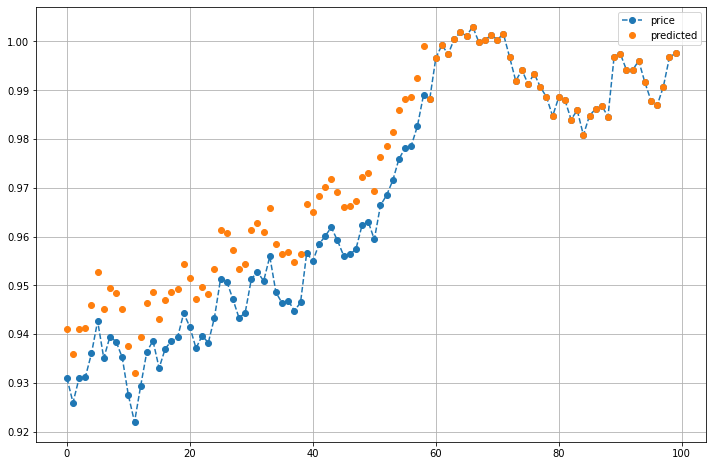

In [15]:
model_gru.eval()
inp = torch.from_numpy(np.array(val_x[:,:,0].reshape(-1, 5,1)))
labs = torch.from_numpy(np.array(val_y_bool[:, 0]))
out = model_gru(inp.float()) #.to('cuda')
outputs = nn.Sigmoid()(out).cpu().detach().numpy().reshape(-1).round()
targets = labs.numpy().reshape(-1)
ACC = np.mean((outputs == targets))
print(ACC)

print(f"nb 0 = {len(outputs[outputs == 0.])}; nb 1 = {len(outputs[outputs == 1.])}")

nb = list(range(100,200))
plt.figure(figsize=(12,8))
plt.plot(val_y[nb,0], 'o--', label='price')
#plt.plot(val_y[-nb:,0]+targets[-nb:]/100+0.001, 'o', label='real')
plt.plot(val_y[nb,0]+outputs[nb]/100, 'o', label='predicted')
plt.legend()
plt.grid()
plt.show()

In [16]:
len(targets[targets==0])/len(targets)

0.5195822454308094

### GRU (ALL features)

In [8]:
def min_max_norm(x_, y_): 
  y_ = y_.copy()
  min = x_.min(axis=1)
  max = x_.max(axis=1)
  d = []
 
  for i in range(x_.shape[2]):
    res = (x_[:,:,i] - min[:,i].reshape(-1,1)) / (max[:,i].reshape(-1,1) - min[:,i].reshape(-1,1))
    d.append(res.reshape(-1,5, 1))
    y_[:,i] = ((y_[:,i].reshape(-1,1) - min[:,i].reshape(-1,1))/ (max[:,i].reshape(-1,1) - min[:,i].reshape(-1,1))).reshape(-1,)
  return np.concatenate(d, axis=2), y_

train_x_norm, train_y_norm = min_max_norm(train_x, train_y)
val_x_norm, val_y_norm  = min_max_norm(val_x, val_y)
test_x_norm, test_y_norm = min_max_norm(test_x, test_y)

In [9]:
model_gru_trend  = ml.GRU_base(
        hidden_size=64,
        num_layers=1,
        input_size=5,
        out_features_lin=64,
        out_features_end=1,
        dropout=0.)
#model_gru_all.to('cuda')
model_gru_trend

GRU_base(
  (gru): GRU(5, 64, batch_first=True)
  (fc0_bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=64, out_features=64, bias=True)
  (fc1_bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)

In [10]:
train_loss, val_loss = pl.train_trend(model_gru_trend, train_x_norm, train_y_bool, val_x_norm, val_y_bool, batch_size_= 512, num_epochs_=60, lr_=0.0001, device_='cpu')


 22%|██▏       | 13/60 [00:01<00:05,  8.21it/s]

Epoch: 12/60
MSE = [train loss mean :  1.06052982] , [val loss mean:  0.47345518, MSE (last) 45.95300%]
nb 0: 114, nb 1: 269


 42%|████▏     | 25/60 [00:03<00:04,  8.25it/s]

Epoch: 24/60
MSE = [train loss mean :  1.03699753] , [val loss mean:  0.47650131, MSE (last) 49.08616%]
nb 0: 186, nb 1: 197


 62%|██████▏   | 37/60 [00:04<00:02,  8.47it/s]

Epoch: 36/60
MSE = [train loss mean :  1.02861514] , [val loss mean:  0.51718886, MSE (last) 53.00261%]
nb 0: 201, nb 1: 182


 82%|████████▏ | 49/60 [00:05<00:01,  8.49it/s]

Epoch: 48/60
MSE = [train loss mean :  1.01771369] , [val loss mean:  0.52980853, MSE (last) 52.74151%]
nb 0: 208, nb 1: 175


100%|██████████| 60/60 [00:07<00:00,  8.33it/s]

Epoch: 60/60
MSE = [train loss mean :  1.01013775] , [val loss mean:  0.53089643, MSE (last) 52.48042%]
nb 0: 211, nb 1: 172


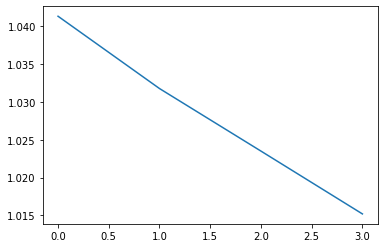

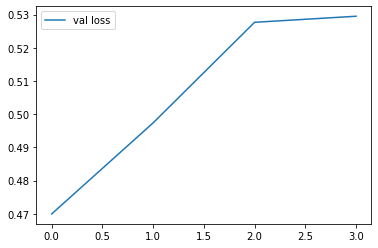

In [11]:
plt.plot(pl.smooth_loss(train_loss, chunksize = 10)[1:] , label="train loss")
plt.show()
plt.plot(pl.smooth_loss(val_loss, chunksize = 10)[1:] , label="val loss")
plt.legend()
plt.show()

nb 0 = 211; nb 1 = 172
0.5248041775456919


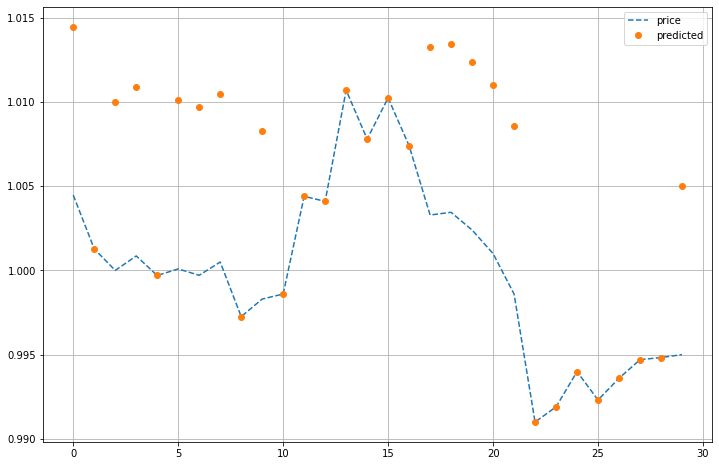

In [12]:
model_gru_trend.eval()
inp = torch.from_numpy(np.array(val_x_norm))
labs = torch.from_numpy(np.array(val_y_bool[:, 0]))
out = model_gru_trend(inp.float()) #.to('cuda')

outputs = nn.Sigmoid()(out).cpu().detach().numpy().reshape(-1).round()
print(f"nb 0 = {len(outputs[outputs == 0.])}; nb 1 = {len(outputs[outputs == 1.])}")
targets = labs.numpy().reshape(-1)
ACC = np.mean((outputs == targets))
print(ACC)

nb = 30
plt.figure(figsize=(12,8))
plt.plot(val_y[-nb:,0], '--', label='price')
#plt.plot(val_y[-nb:,0]+targets[-nb:]/100+0.001, 'o', label='real')
plt.plot(val_y[-nb:,0]+outputs[-nb:]/100, 'o', label='predicted')
plt.legend()
plt.grid()
plt.show()

In [21]:
gru_model_aux = ml.ExchangeRateNet(num_layers=1)
#gru_model_aux.to('cuda')
gru_model_aux

ExchangeRateNet(
  (gru_general): GRU_base(
    (gru): GRU(5, 32, batch_first=True, dropout=0.05)
    (fc0_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc_0): Linear(in_features=32, out_features=32, bias=True)
    (fc1_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc_1): Linear(in_features=32, out_features=1, bias=True)
    (relu): ReLU()
  )
  (gru_ex_reg): GRU_base(
    (gru): GRU(1, 32, batch_first=True, dropout=0.05)
    (fc0_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc_0): Linear(in_features=32, out_features=32, bias=True)
    (fc1_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc_1): Linear(in_features=32, out_features=1, bias=True)
    (relu): ReLU()
  )
  (gru_SPI_reg): GRU_base(
    (gru): GRU(1, 32, batch_first=True, dropout=0.05)
    (fc0_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, t

In [22]:
train_loss, val_loss, aux_loss, aux_loss_val = pl.train_aux_trend(model_gru_trend, gru_model_aux , train_x_norm, train_y_norm, val_x_norm, val_y_norm, batch_size_=512, num_epochs_=200, lr_=0.0001, device_='cpu')


 20%|██        | 40/200 [00:19<01:17,  2.06it/s]

Epoch: 40/200
MSE = [train loss mean :  0.95466520] , [val loss mean:  0.73752841, MSE (last) 65.79542%]
Aux loss train: [close:  1.12267 ], [SMI:  1.15580 ], [SP500:  0.56410 ], [bondCH:  0.67752 ] [bondUS:  0.56281 ] [Gru base:  0.95909]
Aux loss val:   [close:  0.93065 ], [SMI:  1.06901 ], [SP500:  0.46580 ], [bondCH:  0.60966 ] [bondUS:  0.59965 ] [Gru base:  0.76383]


 40%|████      | 80/200 [00:39<00:59,  2.03it/s]

Epoch: 80/200
MSE = [train loss mean :  0.80764181] , [val loss mean:  0.58634875, MSE (last) 53.97508%]
Aux loss train: [close:  0.79818 ], [SMI:  0.68399 ], [SP500:  0.51890 ], [bondCH:  0.58987 ] [bondUS:  0.47120 ] [Gru base:  0.75516]
Aux loss val:   [close:  0.59047 ], [SMI:  0.61478 ], [SP500:  0.38596 ], [bondCH:  0.50825 ] [bondUS:  0.45107 ] [Gru base:  0.55554]


 60%|██████    | 120/200 [01:01<00:38,  2.07it/s]

Epoch: 120/200
MSE = [train loss mean :  0.73805118] , [val loss mean:  0.52222548, MSE (last) 51.24037%]
Aux loss train: [close:  0.74114 ], [SMI:  0.53036 ], [SP500:  0.51417 ], [bondCH:  0.58192 ] [bondUS:  0.46373 ] [Gru base:  0.71384]
Aux loss val:   [close:  0.52696 ], [SMI:  0.47258 ], [SP500:  0.38135 ], [bondCH:  0.50163 ] [bondUS:  0.44305 ] [Gru base:  0.52328]


 80%|████████  | 160/200 [01:20<00:19,  2.06it/s]

Epoch: 160/200
MSE = [train loss mean :  0.70827081] , [val loss mean:  0.50857136, MSE (last) 50.55922%]
Aux loss train: [close:  0.72312 ], [SMI:  0.49077 ], [SP500:  0.51024 ], [bondCH:  0.57216 ] [bondUS:  0.46204 ] [Gru base:  0.69047]
Aux loss val:   [close:  0.52029 ], [SMI:  0.43653 ], [SP500:  0.38146 ], [bondCH:  0.50151 ] [bondUS:  0.44280 ] [Gru base:  0.51186]


100%|██████████| 200/200 [01:40<00:00,  1.99it/s]

Epoch: 200/200
MSE = [train loss mean :  0.68915338] , [val loss mean:  0.50658974, MSE (last) 50.66762%]
Aux loss train: [close:  0.71323 ], [SMI:  0.48433 ], [SP500:  0.51019 ], [bondCH:  0.57349 ] [bondUS:  0.46111 ] [Gru base:  0.67492]
Aux loss val:   [close:  0.52439 ], [SMI:  0.43111 ], [SP500:  0.38326 ], [bondCH:  0.50202 ] [bondUS:  0.44191 ] [Gru base:  0.50631]


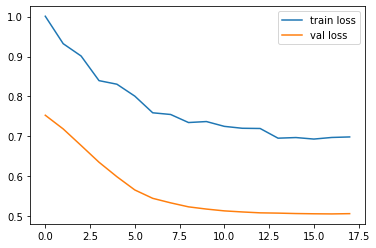

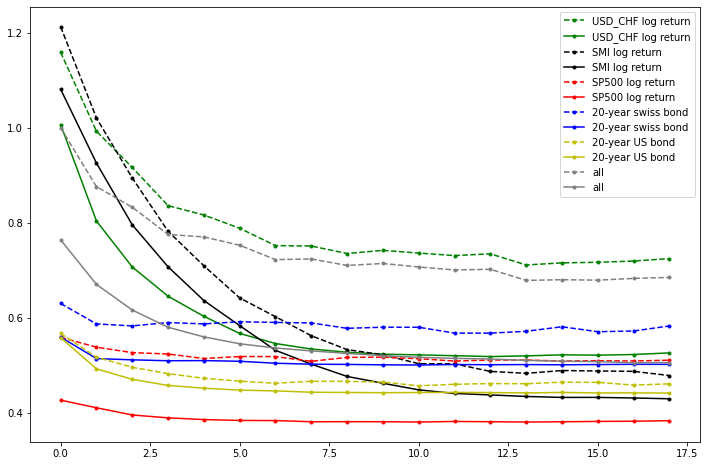

MSE: 54.811716418129244%
REAL MSE: 0.0016462939222503766
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                 5.657e+04
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        20:28:22   Log-Likelihood:                 2764.7
No. Observations:                 676   AIC:                            -5525.
Df Residuals:                     674   BIC:                            -5516.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

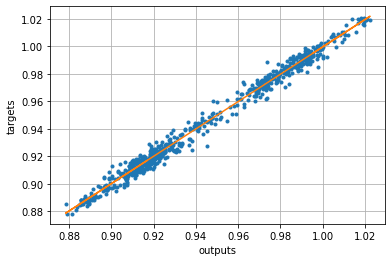

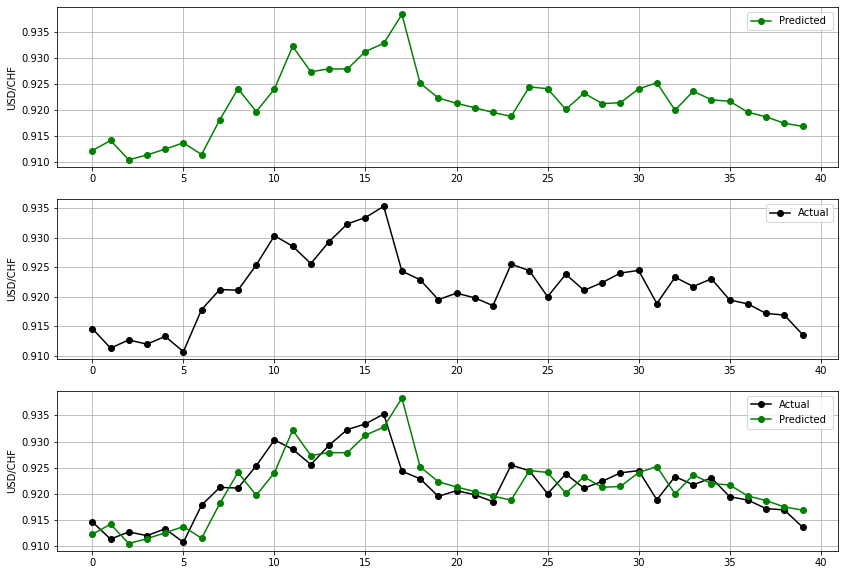

In [23]:
plt.plot(pl.smooth_loss(train_loss, chunksize = 10)[1:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = 10)[1:] , label="val loss")
plt.legend()
plt.show()
plt.figure(figsize=(12,8))
name  = ['USD_CHF log return','SMI log return', 'SP500 log return', '20-year swiss bond', '20-year US bond', 'all']
color= ['g', 'k', 'r', 'b', 'y', 'grey']
for i in range(len(aux_loss)): 
  plt.plot(pl.smooth_loss(aux_loss[i], chunksize = 10)[1:],'.--', label=name[i], c=color[i])
  plt.plot(pl.smooth_loss(aux_loss_val[i], chunksize = 10)[1:],'.-' ,label=name[i], c=color[i])
plt.legend()
plt.show()

outputs, targets, MSE = pl.evaluate_aux_trend(model_gru_trend, gru_model_aux, test_x_norm, test_y_norm, device='cpu') 

min = test_x.min(axis=1)
max = test_x.max(axis=1)
o_aux = outputs.reshape(-1,)* (max[:,0]- min[:,0]) + min[:,0] 
t = targets * (max[:,0]- min[:,0]) + min[:,0]
print("REAL MSE:", np.mean((o_aux-t)**2)*100)

pl.regression_result(t,o_aux)

ds.plot_result_price(o_aux, t, nb=40)